In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

### CCO50- Digital Speech Processing  
# Short Test 6

**Description:** Design an FIR filter (q[n]), subtype I, of order M = 4, to cut-off frequencies within the range 2500 Hz ⇠ 3500 Hz, allowing for all the others to pass through. Assume that the input signal to be filtered (x[n]) was sampled at 10000 samples per second. Normalize the filters’ coefficients in such a way that the filter presents a gain of 0 dB in the pass-band. Lastly, write down the difference equation to filter an input signal x[n] by using q[n]

First, the low-pass filter is calculated for the cut-off frequency of 2500 Hz
$$
h[n] = \frac{\sin{(\omega_c (n - \frac{M}{2}))}}{\pi (n - \frac{M}{2})}, \quad \text{for } n \neq \frac{M}{2}
$$

For $n = \frac{M}{2}$:
$$
h[n] = \frac{\omega_c}{\pi}
\\ \\ \\ \\ \\
\omega_c = \frac{\pi}{2}
$$

$$
h[0] = \frac{\sin{(\frac{\pi}{2} (0 - 2))}}{\pi (0 - 2)} = 0
\\
h[1] = \frac{\sin{(\frac{\pi}{2} (1 - 2))}}{\pi (1 - 2)} = 0.318310
\\
h[2] = \frac{\frac{\pi}{2}}{\pi} = 0.5
\\
h[3] = \frac{\sin{(\frac{\pi}{2} (3 - 2))}}{\pi (3 - 2)} = 0.318310
\\
h[4] = \frac{\sin{(\frac{\pi}{2} (4 - 2))}}{\pi (4 - 2)} = 0
$$

$$
h_{\text{low}} = [0, 0.318, 0.5, 0.318, 0]
$$


To create the high-pass filter, the complement of a low-pass filter calculated for the cut-off frequency of 3500 Hz.

$\omega_c = \frac{7\pi}{10}$

$$
h[0] = \frac{\sin{(\frac{7\pi}{10} (0 - 2))}}{\pi (0 - 2)} = -0.151365
\\
h[1] = \frac{\sin{(\frac{7\pi}{10} (1 - 2))}}{\pi (1 - 2)} = 0.257518
\\
h[2] = \frac{\frac{7\pi}{10}}{\pi} = 0.7
\\
h[3] = \frac{\sin{(\frac{7\pi}{10} (3 - 2))}}{\pi (3 - 2)} = 0.257518
\\
h[4] = \frac{\sin{(\frac{7\pi}{10} (4 - 2))}}{\pi (4 - 2)} = -0.151365
$$
$$
h_{\text{low}} = [-0.151, 0.257, 0.7, 0.257, -0.151]
$$

The all-pass filter:
$$
h_{\text{all}} = [0, 0, 1, 0, 0]
$$

Then subtracting the all pass and the low pass
$$
h_{\text{high}} = h_{\text{all}} - h_{\text{low}}
\\
h_{\text{high}} = [0.151, -0.257, 0.3, -0.257, 0.151]
$$


Finally, the band stop is created with the sum of the low and high pass filters
$$
q[n] = h_{\text{low}} + h_{\text{high}}
\\
q = [0.151, 0.0607, 0.8, 0.0607, 0.151]
$$

## Code implementation

In [155]:
def low_pass_filter(cutoff, sample_rate, M=5):
    nyq = sample_rate / 2
    omega = cutoff / nyq
    h = np.zeros(M+1)
    for n in range(M+1):
        if n == (M/2):
            h[n] = cutoff / nyq
        else:
            h[n] = (np.sin(np.pi * omega * (n - (M/2)))/(np.pi * (n - (M/2))))
    return h

def all_pass_filter(M):
    h = np.zeros(M+1)
    for n in range(M+1):
        if n == (M/2):
            h[n] = 1
        else:
            h[n] = (np.sin(np.pi * (n - (M/2)))/(np.pi * (n - (M/2))))
    return h

def high_pass_filter(cutoff_freq, sample_rate, M):
    lp = low_pass_filter(cutoff_freq, sample_rate, M)
    all_pass = all_pass_filter(M)
    return all_pass - lp


In [136]:
def band_pass_filter(low_cutoff, high_cutoff, sample_rate, M):
    lp = low_pass_filter(high_cutoff, sample_rate, M)
    hp = high_pass_filter(low_cutoff, sample_rate, M)
    return lp - hp

def band_stop_filter(low_cutoff, high_cutoff, sample_rate, M):
    lp = low_pass_filter(low_cutoff, sample_rate, M)
    hp = high_pass_filter(high_cutoff, sample_rate, M)
    return lp + hp

In [156]:
q = band_stop_filter(2500, 3500, 10000, M=4)
print([f"{val:.6f}" for val in q])

['0.151365', '0.060792', '0.800000', '0.060792', '0.151365']


### Normalizing the filter so the coefficients sum up to 1

In [157]:
#normalizing q
q /= np.sum(q)
print([f"{val:.6f}" for val in q])
print(f"Sum of the normalized q: {np.sum(q)}")

['0.123633', '0.049654', '0.653427', '0.049654', '0.123633']
Sum of the normalized q: 0.9999999999999999


### The Difference Equation
Is defined as
$$
y[n] = x[n] * q[n]
\\
Y[z] = X[z] \cdot Q[z]
\\
Y[z] = X[z] \cdot (a + bz^{-1} + cz^{-2} + ...)
\\
Y[z] = aX[z] + bX[z]z^{-1} +  cX[z]z^{-2} + ...
\\
$$

if $X[z]$ is the Z Transform of $x[n]$, then $z^{-k}X[z]$ is the Z Transform of $x[n-k]$

$$
y[n] = ax[n] + bx[n-1] + cx[n-2] + ...
$$

Applying to the normalized filter we have
$$
y[z] = 0.123 x[n] + 0.049 x [n-1] + 0.653 x[n-2] + 0.049 x[n-3] + 0.123x[n-4]
$$

##### Using the Z-tranform to check the filter

In [19]:
def z_transform(x, num_points=1000):
    omega = np.linspace(0, np.pi, num_points)
    z = np.exp(1j * omega)
    X_z = np.zeros_like(z, dtype=complex)
    N = len(x)
    for k in range(N):
        X_z += x[k] * z**(-k)
    return omega, X_z

In [20]:
def plot_z_transform(omega, G_z, name = "G[z]"):
    plt.plot(omega, np.abs(G_z))
    plt.title('Z-Transform of {name}'.format(name=name))
    plt.xlabel('Frequency (omega)')
    plt.ylabel('G(z)')
    plt.grid()
    plt.tight_layout()
    plt.show()


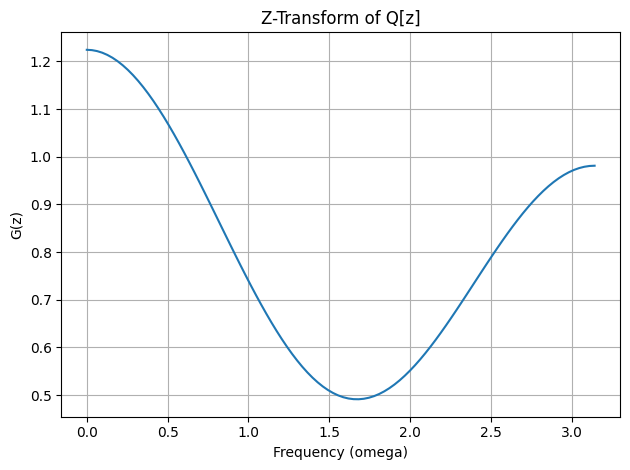

In [140]:
sample_rate = 10000
omega, Q_z = z_transform(q, 100)
plot_z_transform(omega, Q_z, name="Q[z]")

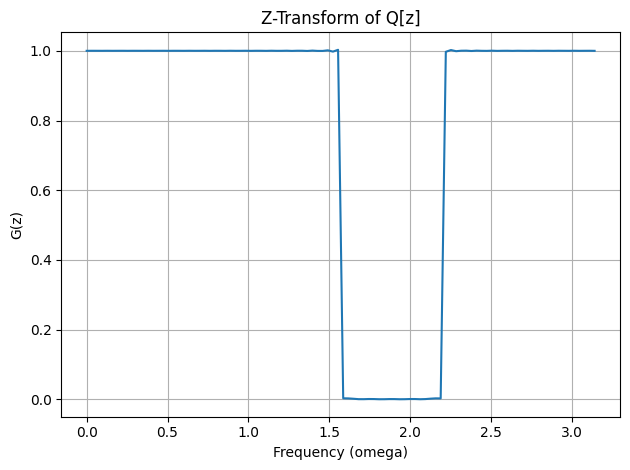

In [143]:
q = band_stop_filter(2500, 3500, 10000, M=5000)
omega, Q_z = z_transform(q, 100)
plot_z_transform(omega, Q_z, name = "Q[z]")


**Author:** Matheus Sinto Novaes <br>
**E-mail:** matheus.sinto@unesp.br

**Course:** Digital Speech Processing <br>
**Professor:** Dr. Eng. Rodrigo Capobianco Guido <br>
**Date:** May 8 2025
